# Foreign Accented English Classification


In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
BRANCH = 'fae/cv22'

RunningInCOLAB = 'google.colab' in str(get_ipython())
# If you're using Google Colab and not running locally, run this cell.
if RunningInCOLAB:
    ## Install dependencies
    %pip install wget
    !apt-get install sox -y
    %pip install unidecode
    %pip install git+https://github.com/schaltung/NeMo.git@{BRANCH}#egg=nemo_toolkit[all]
#    from google.colab import drive
#    drive.mount('/content/drive')
else:
    !apt-get update
    !apt-get install libsox-fmt-all -y
%pip install tensorflow

Get:1 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2183 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [27.5 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1556 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [915 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]    
Get:13 http://archive.ubuntu.com/ubuntu

---
## Introduction


There is an abundance of information available through spoken communication. Besides the words we speak, our voice conveys information about our gender, age, emotion, mood, health and even geo/socioeconomic background. These traits — some long-lived while others short-lived — are collectively known as paralinguistic attributes, making one’s speech a very personal signature closely related to our identity.

This tutorial demonstrates how to classify a speech recording (in English) into one foreign-accent class.

For this demonstration we will be using the [FAE Common Voice 2022](https://github.com/schaltung/FAE-CV) freely available on GitHub. This is a curated version of the crowdsourced corpus [Common Voice corpus](https://commonvoice.mozilla.org/en).

In [2]:
RunningInCOLAB = 'google.colab' in str(get_ipython())  # reload in case kernel was reloaded.
BRANCH = 'fae/cv22'

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import datetime

import os
import json
import wget
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from multiprocessing import Pool
import sox

from omegaconf import OmegaConf
from nemo.collections.asr.models import EncDecSpeakerLabelModel
from matplotlib import pyplot as plt

[NeMo W 2022-10-03 21:37:11 optimizers:77] Could not import distributed_fused_adam optimizer from Apex


---
## Data Preparation

### Locate the Common Voice corpus.

1. Confirm there is a local copy of Common-Voice mounted on `/corpora/{CORPUS_NAME}/{LANGUAGE}`
2. Download a fresh copy otherwise.

In [3]:
# Local copy of Common-Voice corpus.
ROOT = os.getcwd()
#
# Switch the ROOT to the mounted google-drive if available.
if RunningInCOLAB and os.path.exists(os.path.join(ROOT, 'drive', 'MyDrive')):
  ROOT = os.path.join(ROOT, 'drive', 'MyDrive')
#
data_dir = os.path.join(ROOT, "data")
os.makedirs(data_dir, exist_ok=True)
#
# Current version of Mozzilla Common-Voice (English).
CORPUS_NAME = 'cv-corpus-10.0-2022-07-04'
LANGUAGE = 'en'
#
DIR_CORPORA = f'/corpora/{CORPUS_NAME}/{LANGUAGE}'
clips_dir = f'{DIR_CORPORA}/clips'

if os.path.exists(clips_dir):
    print(f"Found existing clips folder: {clips_dir}")
elif RunningInCOLAB:
    import tarfile
    CORPUS_NAME = 'cv-corpus-10.0-2022-07-04' # fixed to this version.
    DIR_CORPORA = f'/content/{CORPUS_NAME}/{LANGUAGE}'
    clips_dir = f'{DIR_CORPORA}/clips'
    !gdown 1_r-XW0E3vJN9X3dYb6n-O-3RleA5LzUF
    !bunzip2 /content/{CORPUS_NAME}_faecv22.tar.bz2
    tar = tarfile.open(f'{CORPUS_NAME}_faecv22.tar')
    tar.extractall('/content')
    tar.close()
    os.remove(f'{CORPUS_NAME}_faecv22.tar')
    !mv /content/cv-corpus-10.0-2022-07-04/en/fae-cv_data_wavs/ /content/data/wavs
else:
    COMMON_VOICE_URL = f"https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/{CORPUS_NAME}/{CORPUS_NAME}-{LANGUAGE}.tar.gz"
    print(f"Could not find Common Voice, downloading corpus...")
    import sys, subprocess, tarfile
    output_archive_filename = f"{data_dir}/cv-en.tar.gz"
    commands = [
        "wget",
        "--user-agent",
        '"Mozilla/5.0 (Windows NT 10.0; WOW64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"',
        "-O",
        output_archive_filename,
        f"{COMMON_VOICE_URL}",
    ]
    commands = " ".join(commands)
    subprocess.run(
        commands, shell=True, capture_output=False
    )
    tar = tarfile.open(output_archive_filename)
    try:
        tar.extractall(DIR_CORPORA)
        print(f"extracted to: {DIR_CORPORA}")
    except:
        print(f"unable to extract to: {DIR_CORPORA}, trying {data_dir} instead.")
        DIR_CORPORA = data_dir
        clips_dir = f'{DIR_CORPORA}/clips'
        tar.extractall(DIR_CORPORA)
        print(f"extracted to: {DIR_CORPORA}")
    tar.close()
    os.remove(output_archive_filename)

Found existing clips folder: /corpora/cv-corpus-10.0-2022-07-04/en/clips


### Download the FAE-CV22 files.

Fetch the a copy of the list files and load them as data frames.

#### Fetch list files from FACE-CV Github.

This version of FAE-CV is from `2022-09-17_21-17-44`. See [config.yaml](https://raw.githubusercontent.com/schaltung/FAE-CV/main/logs/2022-09-17_21-17-44/config.yaml) for configuration criteria.

In [4]:
# Download the FAE-CV22 list files.
# target location to store the slected wav files.
wavs_dir =  os.path.join(data_dir, "wavs")
fae_cv_url = "https://raw.githubusercontent.com/schaltung/FAE-CV/main/logs/2022-09-17_21-17-44"

os.makedirs(wavs_dir, exist_ok=True)

for tsv_file in ('train.tsv', 'test.tsv', 'dev.tsv', 'eval.tsv'):
    tsv_path = os.path.join(data_dir, tsv_file)
    tsv_url = f'{fae_cv_url}/{tsv_file}'
    if not os.path.exists(tsv_path):
        print(f'downloading {tsv_url}')
        wget.download(tsv_url, data_dir)

downloading https://raw.githubusercontent.com/schaltung/FAE-CV/main/logs/2022-09-17_21-17-44/train.tsv
downloading https://raw.githubusercontent.com/schaltung/FAE-CV/main/logs/2022-09-17_21-17-44/test.tsv
downloading https://raw.githubusercontent.com/schaltung/FAE-CV/main/logs/2022-09-17_21-17-44/dev.tsv
downloading https://raw.githubusercontent.com/schaltung/FAE-CV/main/logs/2022-09-17_21-17-44/eval.tsv


#### Load the TSV fileas as dataframes.

The original audio format is `mp3`. We will be transforming it to 16-bit linear PCM `wav` at 16kHz sampling rate.

In [5]:
colnames = ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'locale', 'segment', 'isfemale', 'label', 'duration']
#
trainDF = pd.read_csv(os.path.join(data_dir, 'train.tsv'), sep='\t', names=colnames)
devDF = pd.read_csv(os.path.join(data_dir, 'dev.tsv'), sep='\t', names=colnames)
testDF = pd.read_csv(os.path.join(data_dir, 'test.tsv'), sep='\t', names=colnames)
evalDF = pd.read_csv(os.path.join(data_dir, 'eval.tsv'), sep='\t', names=colnames)

Path(wavs_dir).mkdir(parents=True, exist_ok=True)
trainDF['wavpath'] = trainDF.path.apply(lambda x : os.path.join(wavs_dir, x.replace('.mp3','.wav')))
devDF['wavpath'] = devDF.path.apply(lambda x : os.path.join(wavs_dir, x.replace('.mp3','.wav')))
testDF['wavpath'] = testDF.path.apply(lambda x : os.path.join(wavs_dir, x.replace('.mp3','.wav')))
evalDF['wavpath'] = evalDF.path.apply(lambda x : os.path.join(wavs_dir, x.replace('.mp3','.wav')))


In [6]:
# We know eval.tsv has out-of-set labels. 
# --> map the out-of-set labels to 'us'.
print(evalDF.label.nunique())
std_label_set = testDF.label.unique()
evalDF.loc[:, 'label'] = evalDF.label.apply(lambda x : x if x in std_label_set else 'us')
print(evalDF.label.nunique())

# # Alternatively, we could have removed the entries with out-of-set labels:
# print(evalDF.label.nunique())
# std_label_set = testDF.label.unique()
# evalDF = evalDF[evalDF.label.isin(std_label_set)]
# print(evalDF.label.nunique())

14
11


### Transform recordings from MP3 to 16-bit linear-PCM 16kHz wav files.

* Downsampled to 16kHz
* Gain normalize.

In [7]:
def au_transform(x, tfm=sox.Transformer()):
    tfm.set_output_format(rate=16000)
    tfm.gain(normalize=True)
    in_filepath = os.path.join(clips_dir, x)
    out_filepath = os.path.join(wavs_dir, x.replace('.mp3','.wav'))
    status = tfm.build(input_filepath=in_filepath, output_filepath=out_filepath)
    return status

def get_duration(path):
    return sox.file_info.duration(path)    
#
if RunningInCOLAB:
  print('Running in colab. wav files already downloaded.')
else:
  print('Converting mp3 --> wav... this may take a couple of minutes...')
  MAX_NB_CPU_WORKERS = max(2,min(20, int(os.cpu_count() / 4)))
  with Pool(MAX_NB_CPU_WORKERS) as p:
      p.map( au_transform,  trainDF.path )
      p.map( au_transform,  devDF.path )
      p.map( au_transform,  testDF.path )
      p.map( au_transform,  evalDF.path )
  print('...done!')

Converting mp3 --> wav... this may take a couple of minutes...
...done!


In [8]:
# refresh the duration info after converting to wav as it may have drifted a little.
print('Updating the duration of new wav files.... it may take a minute...')
trainDF['wav_duration'] = trainDF.wavpath.apply(get_duration)
devDF['wav_duration'] = devDF.wavpath.apply(get_duration)
testDF['wav_duration'] = testDF.wavpath.apply(get_duration)
evalDF['wav_duration'] = evalDF.wavpath.apply(get_duration)
print('...done!')

Updating the duration of new wav files.... it may take a minute...
...done!


### Create manifest files.

The schema needed is:
```
{"audio_filepath": str, "offset": float, "duration": float, "label": str}
```

In [9]:
data_dir = 'data'

train_manifest = os.path.join(data_dir,'manifest-train.json')
validation_manifest = os.path.join(data_dir,'manifest-dev.json')
test_manifest = os.path.join(data_dir,'manifest-test.json')
eval_manifest = os.path.join(data_dir,'manifest-eval.json')

In [10]:
manifest_filesL = (train_manifest, validation_manifest, test_manifest, eval_manifest )
dfL = (trainDF, devDF, testDF, evalDF)

# Rename columns
name_mappingD = dict(wavpath='audio_filepath', client_id='speaker', wav_duration='duration')

for manifest_filepath,df in zip(manifest_filesL, dfL):
    df[['wavpath', 'client_id', 'wav_duration', 'label']].rename(name_mappingD, axis=1).to_json(manifest_filepath, orient='records', lines=True)

# ECAPA model

## Fine-tuning. 
### Repurpose a pre-trained Speaker-Recongition DNN model for Speaker-Accent Classification.

We finetune a pretrained Speaker-Recognition model (published on NGC) to accent classification. 

Note: All the following steps are just for explanation of each section, but one can use the provided [FAE recognition script](https://github.com/schaltung/NeMo/blob/fae22/examples/speaker_tasks/paralinguistics/speaker_fae_reco.py) to launch training in the command line.

In [11]:
import torch
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from nemo.collections.asr.models import EncDecSpeakerLabelModel
from nemo.utils.exp_manager import exp_manager
seed_everything(42)

Global seed set to 42


42

### Basic Configuration
The ECAPA model is defined in a config file which declares multiple important sections.

They are:

1) model: All arguments that will relate to the Model - preprocessors, encoder, decoder, optimizer and schedulers, datasets, and any other related information

2) trainer: Any argument to be passed to PyTorch Lightning

In [12]:
!mkdir -p conf
!wget -q -P conf https://raw.githubusercontent.com/schaltung/NeMo/$BRANCH/examples/speaker_tasks/paralinguistics/conf/ecapa_tdnn-finetune-cv.yaml
MODEL_CONFIG = 'conf/ecapa_tdnn-finetune-cv.yaml'
finetune_config = OmegaConf.load(MODEL_CONFIG)
#print(OmegaConf.to_yaml(finetune_config))

### Add the datasets (manifests) to the config.

The config dictionaries called `train_ds`, `validation_ds` and `test_ds` are configurations used to setup the Dataset and DataLoaders of the corresponding config.

In [13]:
print(OmegaConf.to_yaml(finetune_config.model.train_ds))
print(OmegaConf.to_yaml(finetune_config.model.validation_ds))

manifest_filepath: ???
sample_rate: ${model.sample_rate}
labels: null
batch_size: 64
shuffle: true
augmentor:
  speed:
    prob: 0.5
    sr: ${model.sample_rate}
    resample_type: kaiser_fast
    min_speed_rate: 0.95
    max_speed_rate: 1.05

manifest_filepath: ???
sample_rate: ${model.sample_rate}
labels: null
batch_size: 128
shuffle: false



You will often notice that some configs have `???` in place of paths. This is used as a placeholder so that the user can change the value at a later time.

Let's add the paths to the manifests to the config above.

In [14]:
finetune_config.model.train_ds.manifest_filepath = train_manifest
finetune_config.model.validation_ds.manifest_filepath = validation_manifest
finetune_config.model.pop('test_ds', None)

{'manifest_filepath': '???', 'sample_rate': '${model.sample_rate}', 'labels': None, 'batch_size': 128, 'shuffle': False}

Note: Since we are training speaker embedding extractor model for verification we do not add test_ds dataset. To include it add it to config and replace manifest file as 
`config.model.test_ds.manifest_filepath = test_manifest`

Also as we are training on FAE-CV22 dataset, there are 11 accent labels in training, and we need to set this in the decoder config.

In [15]:
print(trainDF.label.nunique())
finetune_config.model.decoder.num_classes = trainDF.label.nunique()

11


### Setup a Trainer and Experiment-Logger

Note: If one would like to finetune from a PTL checkpoint (instead of the NGC public model), `init_from_pretrained_model` in config should be replaced with `init_from_nemo_model` and need to provide the path to checkpoint. 

So far we have set up the data manifest files and changed the decoder required for finetune. We now just need to create a trainer and start training with a smaller learning rate for fewer epochs.

In [16]:
# Setup the new trainer object
# Let us modify some trainer configs for this demo
# Checks if we have GPU available and uses it
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

trainer_config = finetune_config.trainer
trainer_config.accelerator = accelerator

trainer_config.pop('strategy',None)

# DBG:
trainer_config.max_epochs = 5
trainer_config.devices = 1
if RunningInCOLAB:
  print('adjusting configuration for colab.')
  finetune_config.model.train_ds.batch_size = 24
  finetune_config.model.validation_ds.batch_size = 24
  finetune_config.exp_manager.exp_dir = '/content/nemo_experiments'

print(OmegaConf.to_yaml(trainer_config))

devices: 1
max_epochs: 5
max_steps: -1
num_nodes: 1
accelerator: gpu
accumulate_grad_batches: 1
deterministic: false
enable_checkpointing: false
logger: false
log_every_n_steps: 1
val_check_interval: 1.0



In [17]:
trainer_finetune = pl.Trainer(**trainer_config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


### Setting up a NeMo Experiment
NeMo has an experiment manager that handles logging and checkpointing for us, so let's use it !

In [18]:
log_dir_finetune = exp_manager(trainer_finetune, finetune_config.get("exp_manager", None))
print(log_dir_finetune)

[NeMo I 2022-10-03 21:55:10 exp_manager:286] Experiments will be logged at /workspace/nemo_experiments/FAE-ecapa-finetune-CV/2022-10-03_21-55-10
[NeMo I 2022-10-03 21:55:10 exp_manager:660] TensorboardLogger has been set up


[NeMo W 2022-10-03 21:55:10 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:2274: LightningDeprecationWarning: `Trainer.weights_save_path` has been deprecated in v1.6 and will be removed in v1.8.
      rank_zero_deprecation("`Trainer.weights_save_path` has been deprecated in v1.6 and will be removed in v1.8.")
    
[NeMo W 2022-10-03 21:55:10 exp_manager:900] The checkpoint callback was told to monitor a validation value and trainer's max_steps was set to -1. Please ensure that max_steps will run for at least 1 epochs to ensure that checkpointing will not error out.


/workspace/nemo_experiments/FAE-ecapa-finetune-CV/2022-10-03_21-55-10


Create an instance of the model `speaker_model`.

In [19]:
speaker_model = EncDecSpeakerLabelModel(cfg=finetune_config.model, \
    trainer=trainer_finetune)

[NeMo I 2022-10-03 21:56:10 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 21:56:10 collections:301] # 7272 files loaded accounting to # 11 labels


[NeMo W 2022-10-03 21:56:10 label_models:159] Total number of 11 found in all the manifest files.


[NeMo I 2022-10-03 21:56:10 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 21:56:10 collections:301] # 7272 files loaded accounting to # 11 labels
[NeMo I 2022-10-03 21:56:10 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 21:56:10 collections:301] # 916 files loaded accounting to # 11 labels
[NeMo I 2022-10-03 21:56:10 features:223] PADDING: 16
[NeMo I 2022-10-03 21:56:11 label_models:102] loss is Angular Softmax


[NeMo W 2022-10-03 21:56:11 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (TopKClassificationAccuracy). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_full_state_property`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    
[NeMo W 2022-10-03 21:56:11 nemo_logging:349] /opt/c

In [20]:
# Download pretrained model from NGC.
speaker_model.maybe_init_from_pretrained_checkpoint(finetune_config)

[NeMo I 2022-10-03 21:57:10 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/ecapa_tdnn/versions/v1/files/ecapa_tdnn.nemo to /root/.cache/torch/NeMo/NeMo_1.12.0rc0/ecapa_tdnn/20b7839bda482a0b7d4b3390c337d2bc/ecapa_tdnn.nemo
[NeMo I 2022-10-03 21:57:15 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-10-03 21:57:16 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-10-03 21:57:16 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data lo

[NeMo I 2022-10-03 21:57:16 features:223] PADDING: 16
[NeMo I 2022-10-03 21:57:16 label_models:102] loss is Angular Softmax
[NeMo I 2022-10-03 21:57:16 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.12.0rc0/ecapa_tdnn/20b7839bda482a0b7d4b3390c337d2bc/ecapa_tdnn.nemo.
[NeMo I 2022-10-03 21:57:16 modelPT:974] Model checkpoint partially restored from pretrained checkpoint with name `ecapa_tdnn`
[NeMo I 2022-10-03 21:57:16 modelPT:976] The following parameters were excluded from loading from pretrained checkpoint with name `ecapa_tdnn` : ['decoder.final.weight']
[NeMo I 2022-10-03 21:57:16 modelPT:979] Make sure that this is what you wanted!


### Execute finetuning.

In the config, we keep weights of preprocessor and encoder, and attach a new decoder as mentioned in above section to match num of classes of new data

In [21]:
trainer_finetune.fit(speaker_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


[NeMo I 2022-10-03 21:58:11 modelPT:597] Optimizer config = AdamW (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        eps: 1e-08
        foreach: None
        lr: 1e-05
        maximize: False
        weight_decay: 0.0002
    )
[NeMo I 2022-10-03 21:58:11 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f4761378cd0>" 
    will be used during training (effective maximum steps = 570) - 
    Parameters : 
    (warmup_ratio: 0.5
    min_lr: 0
    max_steps: 570
    )



  | Name            | Type                              | Params
----------------------------------------------------------------------
0 | preprocessor    | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder         | ECAPAEncoder                      | 18.1 M
2 | decoder         | SpeakerDecoder                    | 2.8 M 
3 | loss            | AngularSoftmaxLoss                | 0     
4 | _accuracy       | TopKClassificationAccuracy        | 0     
5 | _macro_accuracy | Accuracy                          | 0     
6 | _auroc          | AUROC                             | 0     
----------------------------------------------------------------------
20.9 M    Trainable params
0         Non-trainable params
20.9 M    Total params
83.676    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2022-10-03 21:58:13 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-10-03 21:58:15 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-10-03 21:58:15 label_models:353] val_loss: 12.188


[NeMo W 2022-10-03 21:58:15 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


Training: 0it [00:00, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[NeMo W 2022-10-03 21:58:16 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('global_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
      warning_cache.warn(
    


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 21:59:12 label_models:353] val_loss: 9.204


Epoch 0, global step 114: 'val_loss' reached 9.20358 (best 9.20358), saving model to '/workspace/nemo_experiments/FAE-ecapa-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-ecapa-finetune-CV--val_loss=9.2036-epoch=0.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:00:07 label_models:353] val_loss: 7.567


Epoch 1, global step 228: 'val_loss' reached 7.56731 (best 7.56731), saving model to '/workspace/nemo_experiments/FAE-ecapa-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-ecapa-finetune-CV--val_loss=7.5673-epoch=1.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:01:10 label_models:353] val_loss: 7.473


Epoch 2, global step 342: 'val_loss' reached 7.47324 (best 7.47324), saving model to '/workspace/nemo_experiments/FAE-ecapa-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-ecapa-finetune-CV--val_loss=7.4732-epoch=2.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:02:06 label_models:353] val_loss: 7.383


Epoch 3, global step 456: 'val_loss' reached 7.38272 (best 7.38272), saving model to '/workspace/nemo_experiments/FAE-ecapa-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-ecapa-finetune-CV--val_loss=7.3827-epoch=3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:03:04 label_models:353] val_loss: 7.012


Epoch 4, global step 570: 'val_loss' reached 7.01227 (best 7.01227), saving model to '/workspace/nemo_experiments/FAE-ecapa-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-ecapa-finetune-CV--val_loss=7.0123-epoch=4.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=5` reached.


---
### Saving .nemo file
Now we can save the whole config and model parameters in a single .nemo and we can anytime restore from it

In [22]:
model_nemo_path = os.path.join(log_dir_finetune, "ecapa_fae-cv22-finetune.nemo")
latest_model_nemo_path = os.path.join(log_dir_finetune, '..', "ecapa_fae-cv22-finetune.nemo")

In [23]:
speaker_model.save_to(model_nemo_path)
speaker_model.save_to(latest_model_nemo_path)

---
## Visualize Embeddings with TensorBoard Projector

#### Task: Foreign Accent English classification
#### Model: TitaNet
#### Corpus: FAE-CV22


### Import modules.

In [24]:
# We need to install tensorflow to generate data to visualize the embedding space.
try:
    import tensorflow
except:
    %pip install tensorflow

In [25]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import datetime
import os
import json
from collections import OrderedDict
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from omegaconf import OmegaConf
from nemo.collections.asr.models import EncDecSpeakerLabelModel
from matplotlib import pyplot as plt
import torch
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

---
### Load Speaker-Accent Model and Manifest files.


In [26]:
#ROOT = os.getcwd()
#if os.path.exists(os.path.join(ROOT, 'drive', 'MyDrive')):
#  ROOT = os.path.join(ROOT, 'drive', 'MyDrive')
#data_dir = os.path.join(ROOT, "data")
#log_dir_finetune = '/workspace/nemo_experiments/FAE-finetune-CV'
#model_nemo_path = os.path.join(log_dir_finetune, '..', "ecapa_fae-cv22-finetune.nemo")

train_manifest = os.path.join(data_dir,'manifest-train.json')
validation_manifest = os.path.join(data_dir,'manifest-dev.json')
test_manifest = os.path.join(data_dir,'manifest-test.json')
eval_manifest = os.path.join(data_dir,'manifest-eval.json')

# Model
model_nemo_path = model_nemo_path
#
# Data manifests
test_manifest_filepath = test_manifest
eval_manifest_filepath = eval_manifest
enroll_manifest_filepath = train_manifest

In [27]:
# Define In/Out filepaths
# Select below as needed.
#
conf = OmegaConf.create()
conf["data"] = {}
# IN:
test_title = f'{model_nemo_path.split("/")[-1]}\n{os.path.basename(test_manifest_filepath)}'
conf.data["test"] = dict(\
    manifest_path=test_manifest_filepath, \
    title=test_title
    )
#
eval_title = f'{model_nemo_path.split("/")[-1]}\n{os.path.basename(eval_manifest_filepath)}'
conf.data["eval"] = dict(\
    manifest_path=eval_manifest_filepath,
    title=eval_title
    )
#
enroll_title = f'{model_nemo_path.split("/")[-1]}\n{os.path.basename(enroll_manifest_filepath)}'
conf.data['enroll'] = dict(\
    manifest_path=enroll_manifest_filepath,
    title=enroll_title
    )

In [28]:
print(OmegaConf.to_yaml(conf))

data:
  test:
    manifest_path: data/manifest-test.json
    title: 'ecapa_fae-cv22-finetune.nemo

      manifest-test.json'
  eval:
    manifest_path: data/manifest-eval.json
    title: 'ecapa_fae-cv22-finetune.nemo

      manifest-eval.json'
  enroll:
    manifest_path: data/manifest-train.json
    title: 'ecapa_fae-cv22-finetune.nemo

      manifest-train.json'



---

### Extract Embeddings

#### Get embeddings for the Test Set

The test-set is the FAE-CV "`test.tsv`" file.

In [29]:
# STEP 2.1: Run Test.
#
MANIFEST_FILEPATH = conf.data.test.manifest_path
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

#
(
    test_embs,
    test_logits,
    test_ref_labels,
    test_idx2labD,
) = EncDecSpeakerLabelModel.get_batch_embeddings(
    speaker_model=speaker_model,
    manifest_filepath=MANIFEST_FILEPATH,
    batch_size=32,
    sample_rate=16000,
    device='cuda',
)
test_embs = test_embs / (np.linalg.norm(test_embs, ord=2, axis=-1, keepdims=True))

[NeMo I 2022-10-03 22:17:10 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:17:10 collections:301] # 916 files loaded accounting to # 11 labels


100%|██████████| 29/29 [00:02<00:00, 10.99it/s]


#### Get embeddings for the Eval Set

The eval-set is the FAE-CV "`eval.tsv`" file.

In [30]:
# STEP 2.1: Run Evaluation.
#
MANIFEST_FILEPATH = conf.data.eval.manifest_path

#
(
    eval_embs,
    eval_logits,
    eval_ref_labels,
    eval_idx2labD,
) = EncDecSpeakerLabelModel.get_batch_embeddings(
    speaker_model=speaker_model,
    manifest_filepath=MANIFEST_FILEPATH,
    batch_size=32,
    sample_rate=16000,
    device='cuda',
)
eval_embs = eval_embs / (np.linalg.norm(eval_embs, ord=2, axis=-1, keepdims=True))

[NeMo I 2022-10-03 22:17:13 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:17:13 collections:301] # 388 files loaded accounting to # 11 labels


100%|██████████| 13/13 [00:01<00:00, 11.36it/s]


#### Get embeddings for the Enroll Set

The enroll-set is the within class average of the FAE-CV "`train.tsv`" file.

In [31]:
# Step 2.3
MANIFEST_FILEPATH = conf.data.enroll.manifest_path

(
    enrol_embs, 
    enrol_logits, 
    enrol_ref_labels, 
    enrol_idx2labD,
) = EncDecSpeakerLabelModel.get_batch_embeddings(
    speaker_model=speaker_model, 
    manifest_filepath=MANIFEST_FILEPATH, 
    batch_size=32, 
    sample_rate=16000, 
    device='cuda',
)
# Note that embeddings are unit-vectors.
enrol_embs = enrol_embs / (np.linalg.norm(enrol_embs, ord=2, axis=-1, keepdims=True))
#
centroidsL = []
keyslist = list(eval_idx2labD.keys())
for label_id in keyslist:
    indices = np.where(enrol_ref_labels == label_id)
    embedding = (enrol_embs[indices].sum(axis=0).squeeze()) / len(indices)
    centroidsL.append(embedding)
enrol_embs = np.asarray(centroidsL)
# Project back to a hyper-sphere keeping them as unit-vectors
enrol_embs = enrol_embs / (np.linalg.norm(enrol_embs, ord=2, axis=-1, keepdims=True))

[NeMo I 2022-10-03 22:17:15 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:17:15 collections:301] # 7272 files loaded accounting to # 11 labels


100%|██████████| 228/228 [00:18<00:00, 12.38it/s]


---

### Create Embedding Visualization files

We use the TensorBoard Projector


In [32]:
# Switch this to True to bypass writting.
DRY_RUN = False

exp_dir = os.path.join(finetune_config.exp_manager.exp_dir, finetune_config.name)
tstamp = datetime.datetime.now().isoformat().replace(":", "-")

##### - Test Data Points (FAE-CV22 test.tsv)

Create data file to visualize the embeddings from the `Test` Data.

In [33]:
# Gather vector data
set = 'Test'
vectors = test_embs
metadata = [test_idx2labD[x] for x in test_ref_labels]

In [34]:
# Create SummaryWritter
logdir = f"{exp_dir}/FAEcv22_embs{set}_{tstamp}"
if not DRY_RUN:
    writer = SummaryWriter(logdir)
    writer = SummaryWriter(logdir)
    writer.add_embedding(vectors, metadata)
    writer.close()
print(f"Wrote {vectors.shape[0]} embeddings in a {vectors.shape[1]}-dim space.")

Wrote 916 embeddings in a 192-dim space.


##### - Eval Data Points  (FAE-CV22 eval.tsv)

Create data file to visualize the embeddings from the `Eval` Data.

In [35]:
# Gather vector data
set = 'Eval'
vectors = eval_embs
metadata = [eval_idx2labD[x] for x in eval_ref_labels]

In [36]:
# Create SummaryWritter
logdir = f"{exp_dir}/FAEcv22_embs{set}_{tstamp}"
if not DRY_RUN:
    writer = SummaryWriter(logdir)
    writer = SummaryWriter(logdir)
    writer.add_embedding(vectors, metadata)
    writer.close()
print(f"Wrote {vectors.shape[0]} embeddings in a {vectors.shape[1]}-dim space.")

Wrote 388 embeddings in a 192-dim space.


##### - Enroll Data Points  (FAE-CV22 averaged train.tsv)

Create data file to visualize the embeddings from the `Enroll` Data.

In [37]:
# Gather vector data
set = 'Enroll'
vectors = enrol_embs
metadata = [enrol_idx2labD[x] for x in keyslist]

In [38]:
# Create SummaryWritter
logdir = f"{exp_dir}/FAEcv22_embs{set}_{tstamp}"
if not DRY_RUN:
    writer = SummaryWriter(logdir)
    writer = SummaryWriter(logdir)
    writer.add_embedding(vectors, metadata)
    writer.close()
print(f"Wrote {vectors.shape[0]} embeddings in a {vectors.shape[1]}-dim space.")

Wrote 11 embeddings in a 192-dim space.


##### --> Open Tensorboard Projector to access the interactive visualization of Accent Embeddings.

---

### Create Confussion Matrix

Use the cosine score as similarity measure between an embedding and its enrolled prototype.

In [39]:
cos_sim_sco = np.matmul(test_embs, enrol_embs.T)
hyp_labels = cos_sim_sco.argmax(axis=-1)

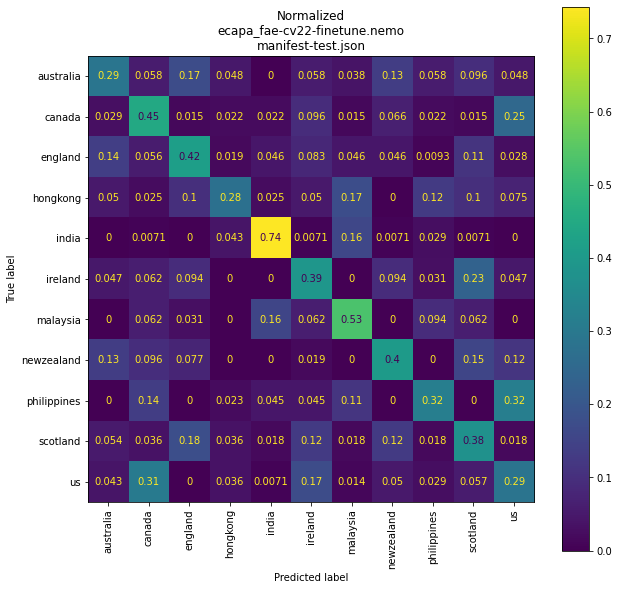

In [40]:
# Confussion Matrix normalized.
TITLE = f'Normalized\n{conf.data.test.title}'
cm = confusion_matrix(test_ref_labels, hyp_labels, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_idx2labD.values())
f = disp.plot(xticks_rotation='vertical').ax_.set_title(TITLE);
f.figure.set_size_inches(10,10)

#### Accuracy

In [41]:
import torchmetrics
num_classes = trainDF.label.nunique()

macroAcc_1best = torchmetrics.Accuracy(num_classes=num_classes, average='macro', top_k=1)
macroAcc_2best = torchmetrics.Accuracy(num_classes=num_classes, average='macro', top_k=2)

microAcc_1best = torchmetrics.Accuracy(num_classes=num_classes, average='micro', top_k=1)
microAcc_2best = torchmetrics.Accuracy(num_classes=num_classes, average='micro', top_k=2)


In [42]:
# TEST
pred_test_sco = torch.tensor(np.matmul(test_embs, enrol_embs.T))
tgt_test = torch.tensor(test_ref_labels)

# Eval
pred_eval_sco = torch.tensor(np.matmul(eval_embs, enrol_embs.T))
tgt_eval = torch.tensor(eval_ref_labels)

In [43]:
resL = [
    dict(metric='macro', nbest=1, set='test', model='ecapa', accuracy=macroAcc_1best(pred_test_sco, tgt_test).tolist()),
    dict(metric='macro', nbest=2, set='test', model='ecapa', accuracy=macroAcc_2best(pred_test_sco, tgt_test).tolist()),
    dict(metric='micro', nbest=1, set='test', model='ecapa', accuracy=microAcc_1best(pred_test_sco, tgt_test).tolist()),
    dict(metric='micro', nbest=2, set='test', model='ecapa', accuracy=microAcc_2best(pred_test_sco, tgt_test).tolist()),
    
    dict(metric='macro', nbest=1, set='eval', model='ecapa', accuracy=macroAcc_1best(pred_eval_sco, tgt_eval).tolist()),
    dict(metric='macro', nbest=2, set='eval', model='ecapa', accuracy=macroAcc_2best(pred_eval_sco, tgt_eval).tolist()),
    dict(metric='micro', nbest=1, set='eval', model='ecapa', accuracy=microAcc_1best(pred_eval_sco, tgt_eval).tolist()),
    dict(metric='micro', nbest=2, set='eval', model='ecapa', accuracy=microAcc_2best(pred_eval_sco, tgt_eval).tolist())
]

In [44]:
pd.DataFrame(resL).groupby(['set', 'metric', 'model','nbest']).first()

accuracy
set  metric model nbest          
eval macro  ecapa 1      0.319890
                  2      0.444655
     micro  ecapa 1      0.286082
                  2      0.461340
test macro  ecapa 1      0.406921
                  2      0.608051
     micro  ecapa 1      0.424672
                  2      0.627729

-----

## Visualize Embedding Space with Tensorboard

#### **Important**: 

* If running in Colab:
  * Use Google Chrome web browser for Tensorboard to work properly.
  * Once Tensorboard loads, hit the 'reload' ↺ button within Tensorboard to enable the `Projector`.
* If running as a docker-container:
  * Tensorboard is already listening to port `6006`. Simply point your web browser to the server host on that port.

The cells below open Tensorboard within collab.

In [45]:
if RunningInCOLAB:
    %load_ext tensorboard

In [46]:
if RunningInCOLAB:
    %tensorboard --logdir /content/nemo_experiments/FAE-finetune-CV/

---

# TitaNet model

## Fine-tuning. 
### Repurpose a pre-trained Speaker-Recongition DNN model for Speaker-Accent Classification.

We finetune a pretrained Speaker-Recognition model (published on NGC) to accent classification. 

Note: All the following steps are just for explanation of each section, but one can use the provided [FAE recognition script](https://github.com/schaltung/NeMo/blob/fae22/examples/speaker_tasks/paralinguistics/speaker_fae_reco.py) to launch training in the command line.

In [47]:
import torch
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from nemo.collections.asr.models import EncDecSpeakerLabelModel
from nemo.utils.exp_manager import exp_manager
seed_everything(42)

Global seed set to 42


42

### Basic Configuration
The TitaNet model is defined in a config file which declares multiple important sections.

They are:

1) model: All arguments that will relate to the Model - preprocessors, encoder, decoder, optimizer and schedulers, datasets, and any other related information

2) trainer: Any argument to be passed to PyTorch Lightning

In [48]:
!mkdir -p conf
!wget -q -P conf https://raw.githubusercontent.com/schaltung/NeMo/$BRANCH/examples/speaker_tasks/paralinguistics/conf/titanet-finetune-cv.yaml
MODEL_CONFIG = 'conf/titanet-finetune-cv.yaml'
finetune_config = OmegaConf.load(MODEL_CONFIG)
#print(OmegaConf.to_yaml(finetune_config))

### Add the datasets (manifests) to the config.

The config dictionaries called `train_ds`, `validation_ds` and `test_ds` are configurations used to setup the Dataset and DataLoaders of the corresponding config.

In [49]:
print(OmegaConf.to_yaml(finetune_config.model.train_ds))
print(OmegaConf.to_yaml(finetune_config.model.validation_ds))

manifest_filepath: ???
sample_rate: ${model.sample_rate}
labels: null
batch_size: 64
shuffle: true
is_tarred: false
tarred_audio_filepaths: null
tarred_shard_strategy: scatter
augmentor:
  speed:
    prob: 0.3
    sr: ${model.sample_rate}
    resample_type: kaiser_fast
    min_speed_rate: 0.95
    max_speed_rate: 1.05

manifest_filepath: ???
sample_rate: ${model.sample_rate}
labels: null
batch_size: 128
shuffle: false



In [50]:
finetune_config.model.train_ds.manifest_filepath = train_manifest
finetune_config.model.validation_ds.manifest_filepath = validation_manifest
finetune_config.model.pop('test_ds', None)

{'manifest_filepath': '???', 'sample_rate': '${model.sample_rate}', 'labels': None, 'batch_size': 128, 'shuffle': False}

Note: Since we are training speaker embedding extractor model for verification we do not add test_ds dataset. To include it add it to config and replace manifest file as 
`config.model.test_ds.manifest_filepath = test_manifest`

Also as we are training on FAE-CV22 dataset, there are 11 accent labels in training, and we need to set this in the decoder config.

In [51]:
print(trainDF.label.nunique())
finetune_config.model.decoder.num_classes = trainDF.label.nunique()

11


### Setup a Trainer and Experiment-Logger

Note: If one would like to finetune from a PTL checkpoint (instead of the NGC public model), `init_from_pretrained_model` in config should be replaced with `init_from_nemo_model` and need to provide the path to checkpoint. 

So far we have set up the data manifest files and changed the decoder required for finetune. We now just need to create a trainer and start training with a smaller learning rate for fewer epochs.

In [52]:
# Setup the new trainer object
# Let us modify some trainer configs for this demo
# Checks if we have GPU available and uses it
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

trainer_config = finetune_config.trainer
trainer_config.accelerator = accelerator

trainer_config.pop('strategy',None)
trainer_config.deterministic = False
# DBG:
trainer_config.max_epochs = 5
trainer_config.devices = 1
if RunningInCOLAB:
  print('adjusting configuration for colab.')
  finetune_config.model.train_ds.batch_size = 24
  finetune_config.model.validation_ds.batch_size = 24
  finetune_config.exp_manager.exp_dir = '/content/nemo_experiments'

print(OmegaConf.to_yaml(trainer_config))

devices: 1
max_epochs: 5
max_steps: -1
num_nodes: 1
accelerator: gpu
deterministic: false
enable_checkpointing: false
logger: false
log_every_n_steps: 1
val_check_interval: 1.0



In [53]:
trainer_finetune = pl.Trainer(**trainer_config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


### Setting up a NeMo Experiment
NeMo has an experiment manager that handles logging and checkpointing for us, so let's use it !

In [54]:
log_dir_finetune = exp_manager(trainer_finetune, finetune_config.get("exp_manager", None))
print(log_dir_finetune)

[NeMo I 2022-10-03 22:17:39 exp_manager:286] Experiments will be logged at /workspace/nemo_experiments/FAE-titaNet-finetune-CV/2022-10-03_21-55-10
[NeMo I 2022-10-03 22:17:39 exp_manager:660] TensorboardLogger has been set up


[NeMo W 2022-10-03 22:17:39 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:2274: LightningDeprecationWarning: `Trainer.weights_save_path` has been deprecated in v1.6 and will be removed in v1.8.
      rank_zero_deprecation("`Trainer.weights_save_path` has been deprecated in v1.6 and will be removed in v1.8.")
    
[NeMo W 2022-10-03 22:17:39 exp_manager:900] The checkpoint callback was told to monitor a validation value and trainer's max_steps was set to -1. Please ensure that max_steps will run for at least 1 epochs to ensure that checkpointing will not error out.


/workspace/nemo_experiments/FAE-titaNet-finetune-CV/2022-10-03_21-55-10


In [55]:
speaker_model = EncDecSpeakerLabelModel(cfg=finetune_config.model, \
    trainer=trainer_finetune)

[NeMo I 2022-10-03 22:17:40 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:17:40 collections:301] # 7272 files loaded accounting to # 11 labels


[NeMo W 2022-10-03 22:17:40 label_models:159] Total number of 11 found in all the manifest files.


[NeMo I 2022-10-03 22:17:40 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:17:40 collections:301] # 7272 files loaded accounting to # 11 labels
[NeMo I 2022-10-03 22:17:40 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:17:40 collections:301] # 916 files loaded accounting to # 11 labels
[NeMo I 2022-10-03 22:17:40 features:223] PADDING: 16
[NeMo I 2022-10-03 22:17:40 label_models:102] loss is Angular Softmax


[NeMo W 2022-10-03 22:17:40 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (TopKClassificationAccuracy). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_full_state_property`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    
[NeMo W 2022-10-03 22:17:40 nemo_logging:349] /opt/c

In [56]:
# Download pretrained model from NGC.
speaker_model.maybe_init_from_pretrained_checkpoint(finetune_config)

[NeMo I 2022-10-03 22:17:40 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/titanet_large/versions/v0/files/titanet-l.nemo to /root/.cache/torch/NeMo/NeMo_1.12.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-10-03 22:17:46 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-10-03 22:17:47 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-10-03 22:17:47 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-10-03 22:17:47 features:223] PADDING: 16
[NeMo I 2022-10-03 22:17:47 label_models:102] loss is Angular Softmax
[NeMo I 2022-10-03 22:17:48 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.12.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-10-03 22:17:48 modelPT:974] Model checkpoint partially restored from pretrained checkpoint with name `titanet_large`
[NeMo I 2022-10-03 22:17:48 modelPT:976] The following parameters were excluded from loading from pretrained checkpoint with name `titanet_large` : ['decoder.final.weight']
[NeMo I 2022-10-03 22:17:48 modelPT:979] Make sure that this is what you wanted!


### Execute finetuning.

In the config, we keep weights of preprocessor and encoder, and attach a new decoder as mentioned in above section to match num of classes of new data

In [57]:
trainer_finetune.fit(speaker_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


[NeMo I 2022-10-03 22:17:48 modelPT:597] Optimizer config = AdamW (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        eps: 1e-08
        foreach: None
        lr: 0.0001
        maximize: False
        weight_decay: 0.0002
    )
[NeMo I 2022-10-03 22:17:48 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f43c8b882e0>" 
    will be used during training (effective maximum steps = 570) - 
    Parameters : 
    (warmup_ratio: 0.1
    min_lr: 0.0
    max_steps: 570
    )



  | Name            | Type                              | Params
----------------------------------------------------------------------
0 | preprocessor    | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder         | ConvASREncoder                    | 19.4 M
2 | decoder         | SpeakerDecoder                    | 2.8 M 
3 | loss            | AngularSoftmaxLoss                | 0     
4 | _accuracy       | TopKClassificationAccuracy        | 0     
5 | _macro_accuracy | Accuracy                          | 0     
6 | _auroc          | AUROC                             | 0     
----------------------------------------------------------------------
22.1 M    Trainable params
0         Non-trainable params
22.1 M    Total params
88.498    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2022-10-03 22:17:48 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-10-03 22:17:49 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-10-03 22:17:49 label_models:353] val_loss: 12.251


[NeMo W 2022-10-03 22:17:49 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:18:36 label_models:353] val_loss: 7.404


Epoch 0, global step 114: 'val_loss' reached 7.40361 (best 7.40361), saving model to '/workspace/nemo_experiments/FAE-titaNet-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-titaNet-finetune-CV--val_loss=7.4036-epoch=0.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:19:27 label_models:353] val_loss: 6.690


Epoch 1, global step 228: 'val_loss' reached 6.69037 (best 6.69037), saving model to '/workspace/nemo_experiments/FAE-titaNet-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-titaNet-finetune-CV--val_loss=6.6904-epoch=1.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:20:18 label_models:353] val_loss: 7.579


Epoch 2, global step 342: 'val_loss' reached 7.57942 (best 6.69037), saving model to '/workspace/nemo_experiments/FAE-titaNet-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-titaNet-finetune-CV--val_loss=7.5794-epoch=2.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:21:10 label_models:353] val_loss: 6.997


Epoch 3, global step 456: 'val_loss' reached 6.99746 (best 6.69037), saving model to '/workspace/nemo_experiments/FAE-titaNet-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-titaNet-finetune-CV--val_loss=6.9975-epoch=3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

[NeMo I 2022-10-03 22:22:03 label_models:353] val_loss: 7.139


Epoch 4, global step 570: 'val_loss' reached 7.13874 (best 6.69037), saving model to '/workspace/nemo_experiments/FAE-titaNet-finetune-CV/2022-10-03_21-55-10/checkpoints/FAE-titaNet-finetune-CV--val_loss=7.1387-epoch=4.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=5` reached.


---
### Saving .nemo file
Now we can save the whole config and model parameters in a single .nemo and we can anytime restore from it

In [58]:
model_nemo_path = os.path.join(log_dir_finetune, "titanet_fae-cv22-finetune.nemo")
latest_model_nemo_path = os.path.join(log_dir_finetune, '..', "titanet_fae-cv22-finetune.nemo")

In [59]:
speaker_model.save_to(model_nemo_path)
speaker_model.save_to(latest_model_nemo_path)

---
## Visualize Embeddings with TensorBoard Projector
#### Task: Foreign Accent English classification
#### Corpus: FAE-CV22
#### Model: TitaNet

### Import modules.

In [60]:
# We need to install tensorflow to generate data to visualize the embedding space.
try:
    import tensorflow
except:
    %pip install tensorflow

In [61]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import datetime
import os
import json
from collections import OrderedDict
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from omegaconf import OmegaConf
from nemo.collections.asr.models import EncDecSpeakerLabelModel
from matplotlib import pyplot as plt
import torch
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

---
### Load Speaker-Accent Model and Manifest files.

In [62]:
#ROOT = os.getcwd()
#if os.path.exists(os.path.join(ROOT, 'drive', 'MyDrive')):
#  ROOT = os.path.join(ROOT, 'drive', 'MyDrive')
#data_dir = os.path.join(ROOT, "data")
#log_dir_finetune = '/workspace/nemo_experiments/FAE-finetune-CV'
#model_nemo_path = os.path.join(log_dir_finetune, '..', "ecapa_fae-cv22-finetune.nemo")

train_manifest = os.path.join(data_dir,'manifest-train.json')
validation_manifest = os.path.join(data_dir,'manifest-dev.json')
test_manifest = os.path.join(data_dir,'manifest-test.json')
eval_manifest = os.path.join(data_dir,'manifest-eval.json')

# Model
model_nemo_path = model_nemo_path
#
# Data manifests
test_manifest_filepath = test_manifest
eval_manifest_filepath = eval_manifest
enroll_manifest_filepath = train_manifest

In [63]:
# Define In/Out filepaths
# Select below as needed.
#
conf = OmegaConf.create()
conf["data"] = {}
# IN:
test_title = f'{model_nemo_path.split("/")[-1]}\n{os.path.basename(test_manifest_filepath)}'
conf.data["test"] = dict(\
    manifest_path=test_manifest_filepath, \
    title=test_title
    )
#
eval_title = f'{model_nemo_path.split("/")[-1]}\n{os.path.basename(eval_manifest_filepath)}'
conf.data["eval"] = dict(\
    manifest_path=eval_manifest_filepath,
    title=eval_title
    )
#
enroll_title = f'{model_nemo_path.split("/")[-1]}\n{os.path.basename(enroll_manifest_filepath)}'
conf.data['enroll'] = dict(\
    manifest_path=enroll_manifest_filepath,
    title=enroll_title
    )

In [64]:
print(OmegaConf.to_yaml(conf))

data:
  test:
    manifest_path: data/manifest-test.json
    title: 'titanet_fae-cv22-finetune.nemo

      manifest-test.json'
  eval:
    manifest_path: data/manifest-eval.json
    title: 'titanet_fae-cv22-finetune.nemo

      manifest-eval.json'
  enroll:
    manifest_path: data/manifest-train.json
    title: 'titanet_fae-cv22-finetune.nemo

      manifest-train.json'



---

### Extract Embeddings

#### Get embeddings for the Test Set

The test-set is the FAE-CV "`test.tsv`" file.

In [65]:
# STEP 2.1: Run Test.
#
MANIFEST_FILEPATH = conf.data.test.manifest_path
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

#
(
    test_embs,
    test_logits,
    test_ref_labels,
    test_idx2labD,
) = EncDecSpeakerLabelModel.get_batch_embeddings(
    speaker_model=speaker_model,
    manifest_filepath=MANIFEST_FILEPATH,
    batch_size=32,
    sample_rate=16000,
    device='cuda',
)
test_embs = test_embs / (np.linalg.norm(test_embs, ord=2, axis=-1, keepdims=True))

[NeMo I 2022-10-03 22:23:15 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:23:15 collections:301] # 916 files loaded accounting to # 11 labels


100%|██████████| 29/29 [00:02<00:00, 12.09it/s]


#### Get embeddings for the Eval Set

The eval-set is the FAE-CV "`eval.tsv`" file.

In [66]:
# STEP 2.1: Run Evaluation.
#
MANIFEST_FILEPATH = conf.data.eval.manifest_path

#
(
    eval_embs,
    eval_logits,
    eval_ref_labels,
    eval_idx2labD,
) = EncDecSpeakerLabelModel.get_batch_embeddings(
    speaker_model=speaker_model,
    manifest_filepath=MANIFEST_FILEPATH,
    batch_size=32,
    sample_rate=16000,
    device='cuda',
)
eval_embs = eval_embs / (np.linalg.norm(eval_embs, ord=2, axis=-1, keepdims=True))

[NeMo I 2022-10-03 22:23:17 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:23:17 collections:301] # 388 files loaded accounting to # 11 labels


100%|██████████| 13/13 [00:01<00:00, 10.31it/s]


#### Get embeddings for the Enroll Set

The enroll-set is the within class average of the FAE-CV "`train.tsv`" file.

In [67]:
# Step 2.3
MANIFEST_FILEPATH = conf.data.enroll.manifest_path

(
    enrol_embs, 
    enrol_logits, 
    enrol_ref_labels, 
    enrol_idx2labD,
) = EncDecSpeakerLabelModel.get_batch_embeddings(
    speaker_model=speaker_model, 
    manifest_filepath=MANIFEST_FILEPATH, 
    batch_size=32, 
    sample_rate=16000, 
    device='cuda',
)
# Note that embeddings are unit-vectors.
enrol_embs = enrol_embs / (np.linalg.norm(enrol_embs, ord=2, axis=-1, keepdims=True))
#
centroidsL = []
keyslist = list(eval_idx2labD.keys())
for label_id in keyslist:
    indices = np.where(enrol_ref_labels == label_id)
    embedding = (enrol_embs[indices].sum(axis=0).squeeze()) / len(indices)
    centroidsL.append(embedding)
enrol_embs = np.asarray(centroidsL)
# Project back to a hyper-sphere keeping them as unit-vectors
enrol_embs = enrol_embs / (np.linalg.norm(enrol_embs, ord=2, axis=-1, keepdims=True))

[NeMo I 2022-10-03 22:23:19 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-10-03 22:23:19 collections:301] # 7272 files loaded accounting to # 11 labels


100%|██████████| 228/228 [00:18<00:00, 12.62it/s]


---

### Create Embedding Visualization files

We use the TensorBoard Projector


In [68]:
# Switch this to True to bypass writting.
DRY_RUN = False

exp_dir = os.path.join(finetune_config.exp_manager.exp_dir, finetune_config.name)
tstamp = datetime.datetime.now().isoformat().replace(":", "-")

##### - Test Data Points (FAE-CV22 test.tsv)

Create data file to visualize the embeddings from the `Test` Data.

In [69]:
# Gather vector data
set = 'Test'
vectors = test_embs
metadata = [test_idx2labD[x] for x in test_ref_labels]

In [70]:
# Create SummaryWritter
logdir = f"{exp_dir}/FAEcv22_embs{set}_{tstamp}"
if not DRY_RUN:
    writer = SummaryWriter(logdir)
    writer = SummaryWriter(logdir)
    writer.add_embedding(vectors, metadata)
    writer.close()
print(f"Wrote {vectors.shape[0]} embeddings in a {vectors.shape[1]}-dim space.")

Wrote 916 embeddings in a 192-dim space.


##### - Eval Data Points  (FAE-CV22 eval.tsv)

Create data file to visualize the embeddings from the `Eval` Data.

In [71]:
# Gather vector data
set = 'Eval'
vectors = eval_embs
metadata = [eval_idx2labD[x] for x in eval_ref_labels]

In [72]:
# Create SummaryWritter
logdir = f"{exp_dir}/FAEcv22_embs{set}_{tstamp}"
if not DRY_RUN:
    writer = SummaryWriter(logdir)
    writer = SummaryWriter(logdir)
    writer.add_embedding(vectors, metadata)
    writer.close()
print(f"Wrote {vectors.shape[0]} embeddings in a {vectors.shape[1]}-dim space.")

Wrote 388 embeddings in a 192-dim space.


##### - Enroll Data Points  (FAE-CV22 averaged train.tsv)

Create data file to visualize the embeddings from the `Enroll` Data.

In [73]:
# Gather vector data
set = 'Enroll'
vectors = enrol_embs
metadata = [enrol_idx2labD[x] for x in keyslist]

In [74]:
# Create SummaryWritter
logdir = f"{exp_dir}/FAEcv22_embs{set}_{tstamp}"
if not DRY_RUN:
    writer = SummaryWriter(logdir)
    writer = SummaryWriter(logdir)
    writer.add_embedding(vectors, metadata)
    writer.close()
print(f"Wrote {vectors.shape[0]} embeddings in a {vectors.shape[1]}-dim space.")

Wrote 11 embeddings in a 192-dim space.


##### --> Open Tensorboard Projector to access the interactive visualization of Accent Embeddings.

---

### Create Confussion Matrix

Use the cosine score as similarity measure between an embedding and its enrolled prototype.

In [75]:
cos_sim_sco = np.matmul(test_embs, enrol_embs.T)
hyp_labels = cos_sim_sco.argmax(axis=-1)

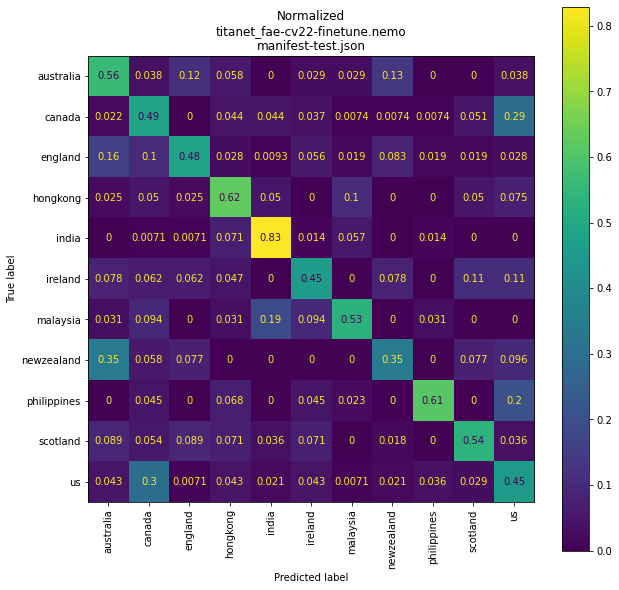

In [76]:
# Confussion Matrix normalized.
TITLE = f'Normalized\n{conf.data.test.title}'
cm = confusion_matrix(test_ref_labels, hyp_labels, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_idx2labD.values())
f = disp.plot(xticks_rotation='vertical').ax_.set_title(TITLE);
f.figure.set_size_inches(10,10)

#### Accuracy

In [77]:
import torchmetrics
num_classes = trainDF.label.nunique()

macroAcc_1best = torchmetrics.Accuracy(num_classes=num_classes, average='macro', top_k=1)
macroAcc_2best = torchmetrics.Accuracy(num_classes=num_classes, average='macro', top_k=2)

microAcc_1best = torchmetrics.Accuracy(num_classes=num_classes, average='micro', top_k=1)
microAcc_2best = torchmetrics.Accuracy(num_classes=num_classes, average='micro', top_k=2)


In [78]:
# TEST
pred_test_sco = torch.tensor(np.matmul(test_embs, enrol_embs.T))
tgt_test = torch.tensor(test_ref_labels)

# Eval
pred_eval_sco = torch.tensor(np.matmul(eval_embs, enrol_embs.T))
tgt_eval = torch.tensor(eval_ref_labels)

In [79]:
resL += [
    dict(metric='macro', nbest=1, set='test', model='titanet', accuracy=macroAcc_1best(pred_test_sco, tgt_test).tolist()),
    dict(metric='macro', nbest=2, set='test', model='titanet', accuracy=macroAcc_2best(pred_test_sco, tgt_test).tolist()),
    dict(metric='micro', nbest=1, set='test', model='titanet', accuracy=microAcc_1best(pred_test_sco, tgt_test).tolist()),
    dict(metric='micro', nbest=2, set='test', model='titanet', accuracy=microAcc_2best(pred_test_sco, tgt_test).tolist()),
    
    dict(metric='macro', nbest=1, set='eval', model='titanet', accuracy=macroAcc_1best(pred_eval_sco, tgt_eval).tolist()),
    dict(metric='macro', nbest=2, set='eval', model='titanet', accuracy=macroAcc_2best(pred_eval_sco, tgt_eval).tolist()),
    dict(metric='micro', nbest=1, set='eval', model='titanet', accuracy=microAcc_1best(pred_eval_sco, tgt_eval).tolist()),
    dict(metric='micro', nbest=2, set='eval', model='titanet', accuracy=microAcc_2best(pred_eval_sco, tgt_eval).tolist())
]

In [80]:
pd.DataFrame(resL).groupby(['set', 'metric', 'model','nbest']).first()

accuracy
set  metric model   nbest          
eval macro  ecapa   1      0.319890
                    2      0.444655
            titanet 1      0.391340
                    2      0.631316
     micro  ecapa   1      0.286082
                    2      0.461340
            titanet 1      0.386598
                    2      0.595361
test macro  ecapa   1      0.406921
                    2      0.608051
            titanet 1      0.537084
                    2      0.724396
     micro  ecapa   1      0.424672
                    2      0.627729
            titanet 1      0.546943
                    2      0.740175

-----

## Visualize Embedding Space with Tensorboard

#### **Important**: 

* If running in Colab:
  * Use Google Chrome web browser for Tensorboard to work properly.
  * Once Tensorboard loads, hit the 'reload' ↺ button within Tensorboard to enable the `Projector`.
* If running as a docker-container:
  * Tensorboard is already listening to port `6006`. Simply point your web browser to the server host on that port.

The cells below open Tensorboard within collab.